In [1]:
import pandas as pd
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [235]:
pd.options.display.max_colwidth = 200

# Compile all together

## Read files

In [4]:
train_df = pd.read_json('train.json', orient='index').sort_index()
train_df['source'] = 'train'

In [5]:
dev_df = pd.read_json('devset.json', orient='index')
dev_df['source'] = 'dev'

In [6]:
test_df = pd.read_json('test-unlabelled.json', orient='index')
test_df['source'] = 'test'

## Generate list of all claims

In [7]:
cols = ['claim', 'source']
claims_df = pd.concat([train_df[cols], dev_df[cols], test_df[cols]]).sort_index()
claims_df.index.name = 'claim_id'
claims_df.to_csv('data/claims.csv')
claims_df.shape

(165447, 2)

In [8]:
claims_df.pivot_table(columns='source', aggfunc='count')

source,dev,test,train
claim,5001,14997,145449


In [9]:
claims_df.head()

,claim,source
claim_id,,
3,Chris Hemsworth appeared in A Perfect Getaway.,train
4,Chris Hemsworth disappeared in A Perfect Getaway.,train
6,Firefox is an application.,test
7,Roald Dahl is a writer.,train
8,Roald Dahl is a governor.,train


## Generate list of labelled claims

In [10]:
lclaims_df = pd.concat([train_df, dev_df]).sort_index()
lclaims_df.index.name = 'claim_id'

In [11]:
lclaims_df.shape

(150450, 4)

In [12]:
lclaims_df['evidence_docs'] = lclaims_df.evidence.apply(lambda x: {item[0] for item in x})
lclaims_df['evidence_doc_count'] = lclaims_df.evidence_docs.apply(lambda x: len(x))
lclaims_df['evidence_sentence_count'] = lclaims_df.evidence.apply(lambda x: len(x))

In [13]:
lclaims_df.head()

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count
claim_id,,,,,,,
3,Chris Hemsworth appeared in A Perfect Getaway.,"[[Chris_Hemsworth, 2]]",SUPPORTS,train,{Chris_Hemsworth},1,1
4,Chris Hemsworth disappeared in A Perfect Getaway.,[],NOT ENOUGH INFO,train,{},0,0
7,Roald Dahl is a writer.,"[[Roald_Dahl, 0]]",SUPPORTS,train,{Roald_Dahl},1,1
8,Roald Dahl is a governor.,"[[Roald_Dahl, 0]]",REFUTES,train,{Roald_Dahl},1,1
9,Ireland has relatively low-lying mountains.,"[[Ireland, 10]]",SUPPORTS,train,{Ireland},1,1


### Evidence Counts

In [14]:
stat_df = lclaims_df.pivot_table(columns='label', index='evidence_doc_count',
                                 values='claim', aggfunc='count', fill_value=0, margins=True)
stat_df[stat_df.All > 100]

label,NOT ENOUGH INFO,REFUTES,SUPPORTS,All
evidence_doc_count,,,,
0,37306,0,0,37306
1,0,26806,67517,94323
2,0,3459,10754,14213
3,0,537,1575,2112
4,0,208,651,859
5,0,148,400,548
6,0,82,248,330
7,0,56,188,244
8,0,43,130,173


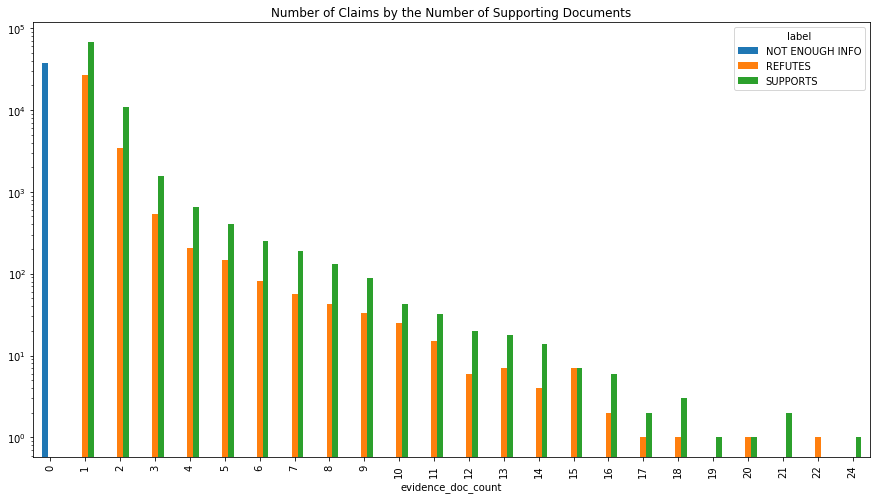

In [15]:
stat_df = lclaims_df.pivot_table(columns='label', index='evidence_doc_count',
                                 values='claim', aggfunc='count', fill_value=0)
stat_df.plot.bar(figsize=(15, 8), logy=True, title='Number of Claims by the Number of Supporting Documents')
plt.show()

### Most Popular Evidence

In [16]:
lclaims_df['evidence_set_str'] = lclaims_df.evidence_docs.astype(str)
mask = lclaims_df.label != 'NOT ENOUGH INFO'
evidence_stat = lclaims_df[mask].evidence_set_str.value_counts()
evidence_stat.index.name = 'evidence_set'
evidence_stat = evidence_stat.reset_index()
evidence_stat.head(20)

,evidence_set,evidence_set_str
0,{'Snoop_Dogg'},166
1,{'Wyatt_Earp'},151
2,{'United_Kingdom'},140
3,{'International_relations'},139
4,{'Marlon_Brando'},137
5,{'United_States'},132
6,{'Adele'},130
7,{'Abraham_Lincoln'},125
8,{'Miley_Cyrus'},120
9,{'Michael_Jackson'},119


In [17]:
evidence_stat = lclaims_df[mask].pivot_table(index=['evidence_set_str', 'evidence_doc_count'], 
                                             values='claim', aggfunc='count').reset_index()

### Claims with Multiple evidence

In [18]:
evidence_stat[evidence_stat.evidence_doc_count > 1].sort_values('claim', ascending=False).head(20)

,evidence_set_str,evidence_doc_count,claim
477,"{'A_Song_of_Ice_and_Fire', 'George_R._R._Martin'}",2,42
1402,"{'Audrey_Horne', 'Pilot_-LRB-Twin_Peaks-RRB-'}",2,32
5920,"{'Hot_-LRB-Mel_B_album-RRB-', 'Mel_B'}",2,26
14462,"{'Warm_Leatherette_-LRB-album-RRB-', 'Grace_Jones'}",2,26
6591,"{'Jay_Baruchel', 'Gift_of_the_Night_Fury'}",2,23
9928,"{'Pat_Nixon', 'Richard_Nixon'}",2,22
13598,"{'This_Sporting_Life', 'Lindsay_Anderson'}",2,20
6142,"{'In_&_Out_-LRB-film-RRB-', 'Joan_Cusack'}",2,20
8991,"{'Mitt_Romney', 'Ann_Romney'}",2,19
5528,"{'Grégory_Levasseur', 'Furia_-LRB-film-RRB-'}",2,19


In [19]:
evidence_stat[evidence_stat.evidence_doc_count > 3].sort_values('claim', ascending=False).head(20)

,evidence_set_str,evidence_doc_count,claim
3522,"{'Days_of_Heaven', 'Richard_Gere', 'American_Gigolo', 'An_Officer_and_a_Gentleman'}",4,7
5127,"{'Gerard_Butler', 'Christopher_Mintz-Plasse', 'Jonah_Hill', 'Jay_Baruchel', 'Gift_of_the_Night_F...",9,7
1896,"{'Birds_in_the_Trap_Sing_McKnight', 'Owl_Pharaoh', 'Days_Before_Rodeo', 'Rodeo_-LRB-Travis_Scott...",5,7
5020,"{'Gendry', 'A_Storm_of_Swords', 'A_Game_of_Thrones', 'A_Clash_of_Kings', 'A_Feast_for_Crows'}",5,5
5250,"{'Gladiator_-LRB-2000_film-RRB-', 'Oliver_Reed', 'The_Trap_-LRB-1966_film-RRB-', 'Castaway_-LRB-...",4,5
3408,"{'Danny_Huston', 'Simon_Pegg', 'How_to_Lose_Friends_&_Alienate_People_-LRB-film-RRB-', 'Max_Ming...",5,5
5028,"{'Gene_Hackman', 'The_Royal_Tenenbaums', 'Owen_Wilson', 'Bill_Murray', 'Luke_Wilson', 'Ben_Still...",7,5
2493,"{'Cameroon', 'Gabon', 'Equatorial_Guinea', 'Republic_of_the_Congo'}",4,4
11447,"{'Scott_Weiland', 'Dean_DeLeo', 'Stone_Temple_Pilots', 'Eric_Kretz', 'Robert_DeLeo'}",5,4
4848,"{'Friends', 'The_Comeback_-LRB-TV_series-RRB-', 'Lisa_Kudrow', 'Web_Therapy_-LRB-TV_series-RRB-'}",4,4


In [20]:
lclaims_df[lclaims_df.evidence_doc_count > 10].head(20)

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count,evidence_set_str
claim_id,,,,,,,,
877,Keith Urban is a singer.,"[[Break_on_Me, 1], [Keith_Urban_-LRB-1991_album-RRB-, 0], [Keith_Urban, 18], [Golden_Road_-LRB-a...",SUPPORTS,train,"{Stupid_Boy, Be_Here, Sweet_Thing_-LRB-Keith_Urban_song-RRB-, Keith_Urban_-LRB-1991_album-RRB-, ...",11,22,"{'Stupid_Boy', 'Be_Here', 'Sweet_Thing_-LRB-Keith_Urban_song-RRB-', 'Keith_Urban_-LRB-1991_album..."
1885,Leonardo DiCaprio is an actor.,"[[Blood_Diamond, 0], [Leonardo_DiCaprio, 8], [Leonardo_DiCaprio, 1], [Inception, 1], [Shutter_Is...",SUPPORTS,train,"{Critters_3, Catch_Me_If_You_Can, Revolutionary_Road_-LRB-film-RRB-, Titanic_-LRB-1997_film-RRB-...",24,40,"{'Critters_3', 'Catch_Me_If_You_Can', 'Revolutionary_Road_-LRB-film-RRB-', 'Titanic_-LRB-1997_fi..."
7253,Laurence Fishburne acted in a movie.,"[[Man_of_Steel_-LRB-film-RRB-, 4], [Othello_-LRB-1995_film-RRB-, 0], [Academy_Award_for_Best_Act...",SUPPORTS,train,"{What's_Love_Got_to_Do_with_It_-LRB-film-RRB-, Batman_v_Superman-COLON-_Dawn_of_Justice, Apocaly...",11,27,"{""What's_Love_Got_to_Do_with_It_-LRB-film-RRB-"", 'Batman_v_Superman-COLON-_Dawn_of_Justice', 'Ap..."
7540,Scarlett Johansson is an actress.,"[[Lucy_-LRB-2014_film-RRB-, 0], [Scarlett_Johansson, 3], [Ghost_World_-LRB-film-RRB-, 0], [Manny...",SUPPORTS,train,"{The_Jungle_Book_-LRB-2016_film-RRB-, The_Prestige_-LRB-film-RRB-, Girl_with_a_Pearl_Earring_-LR...",21,38,"{'The_Jungle_Book_-LRB-2016_film-RRB-', 'The_Prestige_-LRB-film-RRB-', 'Girl_with_a_Pearl_Earrin..."
7541,Scarlett Johansson is an actress in films.,"[[Girl_with_a_Pearl_Earring_-LRB-film-RRB-, 16], [Lucy_-LRB-2014_film-RRB-, 0], [Ghost_World_-LR...",SUPPORTS,train,"{North_-LRB-1994_film-RRB-, Lost_in_Translation_-LRB-film-RRB-, Lucy_-LRB-2014_film-RRB-, BAFTA_...",20,40,"{'North_-LRB-1994_film-RRB-', 'Lost_in_Translation_-LRB-film-RRB-', 'Lucy_-LRB-2014_film-RRB-', ..."
7623,Slovakia is a warship.,"[[Slovakia, 4], [Democracy_Index, 0], [Slovakia, 19], [Social_security, 6], [Slovakia, 26], [Slo...",REFUTES,train,"{Democracy_Index, Council_of_Europe, Developed_country, European_Union, Organisation_for_Economi...",16,39,"{'Democracy_Index', 'Council_of_Europe', 'Developed_country', 'European_Union', 'Organisation_fo..."
7747,Julie Christie starred in a film.,"[[The_Go-Between_-LRB-1971_film-RRB-, 0], [Away_from_Her, 0], [Julie_Christie, 8], [Darling_-LRB...",SUPPORTS,train,"{Far_from_the_Madding_Crowd_-LRB-1967_film-RRB-, Harry_Potter_and_the_Prisoner_of_Azkaban_-LRB-f...",13,17,"{'Far_from_the_Madding_Crowd_-LRB-1967_film-RRB-', 'Harry_Potter_and_the_Prisoner_of_Azkaban_-LR..."
7886,George W. Bush was a president.,"[[George_W._Bush, 10], [George_W._Bush, 28], [Barbara_Bush, 1], [George_W._Bush, 5], [United_Sta...",SUPPORTS,train,"{United_States_presidential_election,_2000, George_W._Bush_Presidential_Center, Patriot_Act, Lis...",14,30,"{'United_States_presidential_election,_2000', 'George_W._Bush_Presidential_Center', 'Patriot_Act..."
8089,Gennady Golovkin boxes.,"[[Gennady_Golovkin, 5], [Interim_championship, 0], [Milton_Núñez_-LRB-boxer-RRB-, 1], [Gennady...",SUPPORTS,train,"{Transnational_Boxing_Rankings_Board, Knockout, BoxRec, Interim_championship, Boxing_styles_and_...",16,28,"{'Transnational_Boxing_Rankings_Board', 'Knockout', 'BoxRec', 'Interim_championship', 'Boxing_st..."


In [21]:
lclaims_df.to_json('data/l_claims.json')

# Explore claims

In [22]:
#!sudo python3 -m pip install spacy
#!sudo python3 -m spacy download en_core_web_lg

In [23]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

In [24]:
def parse_with_spacy(text):
    doc = nlp(text)
    record = dict(
        named_entities = [{'entity': span.text, 'label': span.label_, 'root': span.root.text} for span in doc.ents],
        noun_phrases = [{'noun_phrase': span.text, 'root': span.root.text} for span in doc.noun_chunks]
    )
    return record

## Read Claims list

In [25]:
claims_df = pd.read_csv('data/claims.csv', index_col='claim_id')

## Calculate features

!python3 -m pip install pandarallel

In [26]:
#!sudo python3 -m pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [27]:
from pandarallel import pandarallel

In [ ]:
%%time
pandarallel.initialize(progress_bar=True, nb_workers=4)
features = claims_df.claim.parallel_apply(parse_with_spacy)

In [ ]:
features.name = 'parse'
claims_df = claims_df.join(features)

%%time
records = []
for claim_id, claim in claims_df.claim.items():
    if (claim_id % 1000 == 0):
        print(claim_id)
    
    record = parse_with_spacy(claim)
    record['claim_id'] = claim_id
    records.append(record)
    #print()

In [ ]:
claims_features_df = claims_df

In [ ]:
#claims_features_df = pd.DataFrame.from_records(records, index='claim_id')
#claims_features_df.rename(columns={'noun_chunks': 'noun_phrases'}, inplace=True)

In [ ]:
claims_features_df['entity_count'] = claims_features_df.parse.apply(lambda x: len(x['named_entities']))
claims_features_df['entity_types'] = claims_features_df.parse.apply(lambda x: {item['label'] for item in x['named_entities']})
claims_features_df['entity_types_count'] = claims_features_df.entity_types.apply(len)

In [ ]:
claims_features_df['np_count'] = claims_features_df.parse.apply(lambda x: len(x['noun_phrases']))
func = lambda x: {item['noun_phrase'] for item in x['noun_phrases']}
claims_features_df['np_phrase'] = claims_features_df.parse.apply(func)
claims_features_df['np_roots'] = claims_features_df.parse.apply(lambda x: {item['root'] for item in x['noun_phrases']})

## Export claims with features

In [ ]:
#del claims_df[]

In [ ]:
#claims_df = claims_df.join(claims_features_df)

In [ ]:
claims_df.head(5)

In [ ]:
claims_df.to_json('data/claims_lm.json')

## Top entity types

In [ ]:
claims_features_df['entity_types_str'] = claims_features_df.entity_types.astype(str)
claims_features_df.reset_index(inplace=True)
#claims_data_df['entity_types_count'] = claims_data_df.entity_types.apply(len)

In [ ]:
claims_features_df

In [ ]:
df = claims_features_df.pivot_table(index=['entity_types_count', 'entity_types_str'], 
                           aggfunc='count', values='claim_id').reset_index()
df.rename(columns={'claim_id': 'claims_count'}, inplace=True)
df.sort_values(['entity_types_count', 'claims_count'], ascending=[True, False]).reset_index(drop=True)

In [ ]:
df = claims_features_df.pivot_table(index=['np_count'], 
                           aggfunc='count', values='claim_id').reset_index()
df.rename(columns={'claim_id': 'claims_count'}, inplace=True)
df.sort_values(['np_count'], ascending=[True]).reset_index(drop=True)

In [ ]:
claims_df[claims_df.np_count == 0]

# Evidence Analysis

## Golden evidence list

In [204]:
evidence_items = [((page_id, sent_id), claim_id) 
                    for claim_id, evidence in lclaims_df.evidence.items() 
                    for page_id, sent_id in evidence]

golden_evidence_df = pd.DataFrame(evidence_items, columns=['evidence', 'claim_id']).set_index('evidence')

In [205]:
golden_evidence_df = golden_evidence_df.join(claims_df, on='claim_id')

In [206]:
golden_evidence_df.head()

,claim_id,claim,source
evidence,,,
"(Chris_Hemsworth, 2)",3,Chris Hemsworth appeared in A Perfect Getaway.,train
"(Roald_Dahl, 0)",7,Roald Dahl is a writer.,train
"(Roald_Dahl, 0)",8,Roald Dahl is a governor.,train
"(Ireland, 10)",9,Ireland has relatively low-lying mountains.,train
"(Ireland, 10)",10,Ireland does not have relatively low-lying mountains.,train


In [207]:
golden_evidences = set(golden_evidence_df.index.values)

## Extract golden evidence sentences

In [120]:
import os
import io
import re
from zipfile import ZipFile
import unicodedata

In [121]:
def read_shard(zf, path):
    items = []
    fp = zf.open(path, mode='r')
    tfp = io.TextIOWrapper(fp)
    nlines = 0
    for line in tfp.readlines():
        nlines += 1
        line = unicodedata.normalize('NFD', line)
        match = re.match("(\S+)\s(\d+)\s(.*)\n", line)
        if match:
            items.append(match.groups())
        else:
            #print(line)
            pass
    fp.close()
    tfp.close()
    return items#, nlines

In [122]:
zf = ZipFile("wiki-pages-text.zip")
files = [item.filename for item in zf.filelist]
len(files)

110

In [123]:
golden_sentences = []

for path in sorted(files[1:]):
    shard = ""
    m = re.match(".*wiki-(\d+).txt", path)
    if m: shard = m.groups()[0]
    print(path, shard)
    
    items = read_shard(zf, path)
    filtered_items = [((page_id, int(sent_id)), text, shard) 
                        for page_id, sent_id, text in items 
                        if (page_id, int(sent_id)) in golden_evidences
                       ]
    golden_sentences += filtered_items

wiki-pages-text/wiki-001.txt 001
wiki-pages-text/wiki-002.txt 002
wiki-pages-text/wiki-003.txt 003
wiki-pages-text/wiki-004.txt 004
wiki-pages-text/wiki-005.txt 005
wiki-pages-text/wiki-006.txt 006
wiki-pages-text/wiki-007.txt 007
wiki-pages-text/wiki-008.txt 008
wiki-pages-text/wiki-009.txt 009
wiki-pages-text/wiki-010.txt 010
wiki-pages-text/wiki-011.txt 011
wiki-pages-text/wiki-012.txt 012
wiki-pages-text/wiki-013.txt 013
wiki-pages-text/wiki-014.txt 014
wiki-pages-text/wiki-015.txt 015
wiki-pages-text/wiki-016.txt 016
wiki-pages-text/wiki-017.txt 017
wiki-pages-text/wiki-018.txt 018
wiki-pages-text/wiki-019.txt 019
wiki-pages-text/wiki-020.txt 020
wiki-pages-text/wiki-021.txt 021
wiki-pages-text/wiki-022.txt 022
wiki-pages-text/wiki-023.txt 023
wiki-pages-text/wiki-024.txt 024
wiki-pages-text/wiki-025.txt 025
wiki-pages-text/wiki-026.txt 026
wiki-pages-text/wiki-027.txt 027
wiki-pages-text/wiki-028.txt 028
wiki-pages-text/wiki-029.txt 029
wiki-pages-text/wiki-030.txt 030
wiki-pages

## Analyse golden evidences

In [208]:
df = pd.DataFrame(golden_sentences, columns=['evidence', 'text', 'shard']).set_index('evidence')

In [209]:
golden_evidence_df = golden_evidence_df.join(df)

In [219]:
golden_evidence_df['sentence_tokens_count'] = golden_evidence_df.text.apply(lambda x: len(x.split(' ')))
func = lambda x: len([item for item in x.split(" ") if item.isalnum()])
golden_evidence_df['sentence_words_count'] = golden_evidence_df.text.apply(func)

In [220]:
def estimate_performance(df, param, generator):
    results = []
    for threshold in generator:
        mask = df[param] >= threshold
        true_positives = mask.sum()
        items_count = df[mask].shape[0]
        results.append((threshold, items_count, true_positives))

    return pd.DataFrame(results, columns=['threshold', 'records_count', 'true_positives']).set_index('threshold')

In [221]:
gld_ev_sent_count = golden_evidence_df.shape[0]

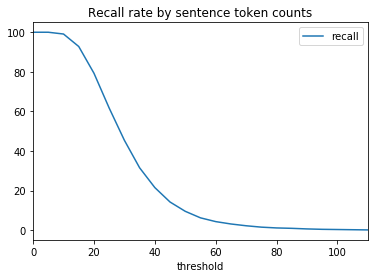

,records_count,true_positives,recall
threshold,,,
0,209743,209743,100.0
5,209707,209707,100.0
10,207901,207901,99.1
15,194729,194729,92.8
20,166258,166258,79.3
25,129338,129338,61.7
30,95142,95142,45.4
35,66024,66024,31.5
40,45113,45113,21.5


In [222]:
df = estimate_performance(golden_evidence_df, 'sentence_tokens_count', range(0, 111, 5))
df['recall'] = df.true_positives.apply(lambda x: round(x / float(gld_ev_sent_count) * 100, 1))
df[['recall']].plot.line(title='Recall rate by sentence token counts')
plt.show()
df

path = 'wiki-pages-text/wiki-014.txt'

items = []
fp = zf.open(path, mode='r')
tfp = io.TextIOWrapper(fp)
nlines = 0
for line in tfp.readlines():
    nlines += 1
    line = unicodedata.normalize('NFD', line)
    if line.find('Bee_Gees') >= 0:
        print(line)
fp.close()
tfp.close()

In [223]:
mask = golden_evidence_df.sentence_tokens_count > 5
golden_evidence_df[mask].sort_values('sentence_tokens_count', ascending=False).head()

,claim_id,claim,source,text,shard,sentence_tokens_count,sentence_words_count
evidence,,,,,,,
"(Norse_mythology, 4)",54723,Odin is a god.,train,"Numerous gods are mentioned in the source texts such as the hammer-wielding , humanity-protectin...",072,185,149
"(Rhona_Mitra, 5)",111327,Rhona Mitra is not an actress.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(Rhona_Mitra, 5)",11550,Rhona Mitra is an actress.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(Rhona_Mitra, 5)",32538,Rhona Mitra is a cat.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(Rhona_Mitra, 5)",62592,Rhona Mitra is female.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118


In [224]:
mask = golden_evidence_df.sentence_tokens_count > 100
golden_evidence_df[mask].sort_values('sentence_tokens_count', ascending=False)

,claim_id,claim,source,text,shard,sentence_tokens_count,sentence_words_count
evidence,,,,,,,
"(Norse_mythology, 4)",54723,Odin is a god.,train,"Numerous gods are mentioned in the source texts such as the hammer-wielding , humanity-protectin...",072,185,149
"(Rhona_Mitra, 5)",11550,Rhona Mitra is an actress.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(Rhona_Mitra, 5)",32538,Rhona Mitra is a cat.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(Rhona_Mitra, 5)",62592,Rhona Mitra is female.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(Rhona_Mitra, 5)",84974,Rhona Mitra is a performer.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(Rhona_Mitra, 5)",94287,Rhona Mitra acts.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(Rhona_Mitra, 5)",111327,Rhona Mitra is not an actress.,train,"After completing her stint as Lara Croft , she concentrated on acting and is known for her roles...",081,151,118
"(The_100_-LRB-TV_series-RRB-, 4)",130059,The 100 is not a TV series following a group of teens.,dev,"The series follows a group of teens : Clarke Griffin -LRB- Eliza Taylor -RRB- , Bellamy Blake -L...",094,148,101
"(The_100_-LRB-TV_series-RRB-, 4)",110351,The 100 does not follow character Clarke Griffin.,dev,"The series follows a group of teens : Clarke Griffin -LRB- Eliza Taylor -RRB- , Bellamy Blake -L...",094,148,101


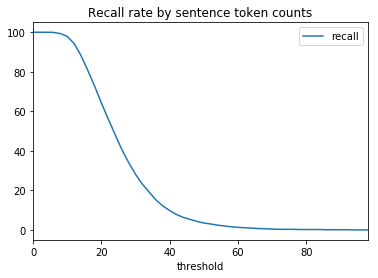

,records_count,true_positives,recall
threshold,,,
0,209743,209743,100.0
2,209728,209728,100.0
4,209706,209706,100.0
6,209538,209538,99.9
8,208307,208307,99.3
10,205295,205295,97.9
12,197710,197710,94.3
14,185207,185207,88.3
16,169376,169376,80.8


In [225]:
df = estimate_performance(golden_evidence_df, 'sentence_words_count', range(0, 100, 2))
df['recall'] = df.true_positives.apply(lambda x: round(x / float(gld_ev_sent_count) * 100, 1))
df[['recall']].plot.line(title='Recall rate by sentence token counts')
plt.show()
df

In [230]:
mask = (golden_evidence_df.sentence_words_count < 4) & (golden_evidence_df.sentence_tokens_count >= 5)
golden_evidence_df[mask].sort_values('sentence_tokens_count', ascending=False)

,claim_id,claim,source,text,shard,sentence_tokens_count,sentence_words_count
evidence,,,,,,,
"(Maharashtra, 0)",125047,Telangana is the northernmost Indian state.,train,"Maharashtra -LRB- -LSB- mahh@'rahshtr@ -RSB- -LSB- məharaːʂʈrə -RSB- , abbr .",063,11,3
"(Carol_Leifer, 0)",83202,Carol Leifer has been nominated for four Emmy Awards.,train,Carol Leifer -LRB- -LSB- ˈliːfər -RSB- ;,018,7,3
"(Carol_Leifer, 0)",141242,"In 1956, Carol Leifer was born.",train,Carol Leifer -LRB- -LSB- ˈliːfər -RSB- ;,018,7,3
"(Hawaii, 0)",78952,Hawaii is a state.,train,Hawaii -LRB- -LSB- langpronaudio = en-us-Hawaii .,042,7,2
"(Hawaii, 0)",83399,"Of the states in America, Hawaii has the 4th most miles of coastline.",train,Hawaii -LRB- -LSB- langpronaudio = en-us-Hawaii .,042,7,2
"(Hawaii, 0)",124806,"Hawaii has the fourth longest coastline of any state, behind Florida, Alaska, and California.",train,Hawaii -LRB- -LSB- langpronaudio = en-us-Hawaii .,042,7,2
"(Hawaii, 0)",154476,Hawaii is an entity with statehood.,train,Hawaii -LRB- -LSB- langpronaudio = en-us-Hawaii .,042,7,2
"(Montreal, 0)",82558,Montreal is not in Canada.,train,Montreal -LRB- -LSB- audio = Montreal-English-pronunciation .,068,7,2
"(Montreal, 0)",102619,Montreal is a city in Canada.,train,Montreal -LRB- -LSB- audio = Montreal-English-pronunciation .,068,7,2


In [239]:
mask = 1. * golden_evidence_df.sentence_words_count / golden_evidence_df.sentence_tokens_count < 0.3
golden_evidence_df[mask].sort_values('sentence_tokens_count', ascending=False)

,claim_id,claim,source,text,shard,sentence_tokens_count,sentence_words_count
evidence,,,,,,,
"(Bangladesh, 0)",10025,Bangladesh is a country.,train,"Bangladesh -LRB- -LSB- bæŋɡləˈdɛʃ -RSB- -LSB- ˌbɑːŋɡləˈdɛʃ -RSB- -LSB- : bn : বাংলাদেশ , বাংলাদেশ -RSB- , -LSB- ˈbaŋlad̪eʃ -RSB- , lit .",012,23,5
"(Bangladesh, 0)",18692,Bangladesh is on the Indian subcontinent.,train,"Bangladesh -LRB- -LSB- bæŋɡləˈdɛʃ -RSB- -LSB- ˌbɑːŋɡləˈdɛʃ -RSB- -LSB- : bn : বাংলাদেশ , বাংলাদেশ -RSB- , -LSB- ˈbaŋlad̪eʃ -RSB- , lit .",012,23,5
"(Bangladesh, 0)",33282,Bangladesh is a nation.,train,"Bangladesh -LRB- -LSB- bæŋɡləˈdɛʃ -RSB- -LSB- ˌbɑːŋɡləˈdɛʃ -RSB- -LSB- : bn : বাংলাদেশ , বাংলাদেশ -RSB- , -LSB- ˈbaŋlad̪eʃ -RSB- , lit .",012,23,5
"(Bangladesh, 0)",50933,Bangladesh is in South America.,train,"Bangladesh -LRB- -LSB- bæŋɡləˈdɛʃ -RSB- -LSB- ˌbɑːŋɡləˈdɛʃ -RSB- -LSB- : bn : বাংলাদেশ , বাংলাদেশ -RSB- , -LSB- ˈbaŋlad̪eʃ -RSB- , lit .",012,23,5
"(Bangladesh, 0)",67258,Bangladesh has been affected by poverty and violence.,train,"Bangladesh -LRB- -LSB- bæŋɡləˈdɛʃ -RSB- -LSB- ˌbɑːŋɡləˈdɛʃ -RSB- -LSB- : bn : বাংলাদেশ , বাংলাদেশ -RSB- , -LSB- ˈbaŋlad̪eʃ -RSB- , lit .",012,23,5
"(Maharashtra, 0)",125047,Telangana is the northernmost Indian state.,train,"Maharashtra -LRB- -LSB- mahh@'rahshtr@ -RSB- -LSB- məharaːʂʈrə -RSB- , abbr .",063,11,3
"(Hawaii, 0)",78952,Hawaii is a state.,train,Hawaii -LRB- -LSB- langpronaudio = en-us-Hawaii .,042,7,2
"(Hawaii, 0)",83399,"Of the states in America, Hawaii has the 4th most miles of coastline.",train,Hawaii -LRB- -LSB- langpronaudio = en-us-Hawaii .,042,7,2
"(Hawaii, 0)",124806,"Hawaii has the fourth longest coastline of any state, behind Florida, Alaska, and California.",train,Hawaii -LRB- -LSB- langpronaudio = en-us-Hawaii .,042,7,2


### Shards vs Number of evidence Sentences 

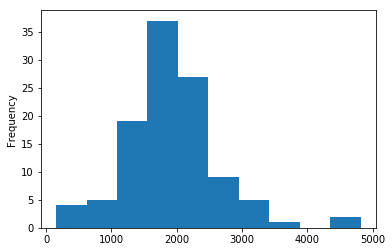

In [152]:
golden_evidence_df.shard.value_counts().plot.hist()
plt.show('Distribution of evidences in 1 shard')